# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import collections
import cv2
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import tensorflow as tf
import time
from skimage import io
from collections import Counter
from matplotlib import cm

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu

from sklearn.utils import shuffle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

images='/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


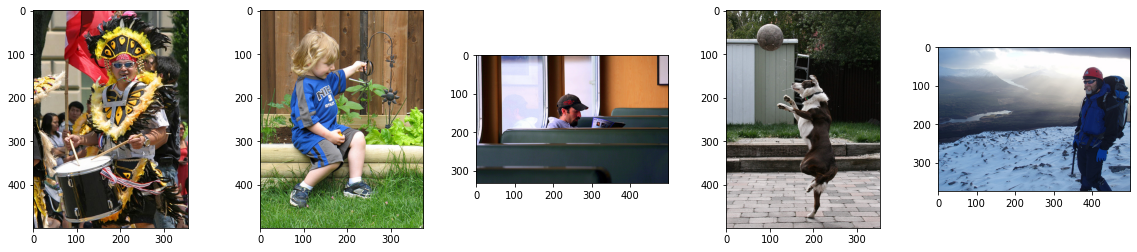

In [4]:
#Visualise both the images & text present in the dataset

#Visualising first 5 images:
Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)


In [5]:
#Import the dataset and read the text file into a seperate variable

text_file = "/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/captions.txt"
def load_doc(filename):
    
    #your code here
    open_text_file = open(filename, 'r', encoding="latin-1") #associate and returns a file object
    text = open_text_file.read() #for reading the content of the file
    open_text_file.close()    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [6]:
image_path='/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Eye_for_blind-upgrad_c...,A rock climber in a red shirt


In [7]:
df.info()#information of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [8]:
#Create a list which contains all the captions
annotations=[i for i in df['Captions']]
print('Example captions from the dataset:\n',annotations[:10], '\n','*'*100)

#add the <start> & <end> token to all those captions as well
annotations = ['<start> '+i+' <end>' for i in annotations]
print('Example captions after adding start and end tokens:\n',annotations[:10], '\n','*'*100)

#Create a list which contains all the path to the images
all_img_path=[i for i in df['Path']]
print('Example paths for images:\n',all_img_path[:10], '\n','*'*100)

print("Total captions present in the dataset: \n"+ str(len(annotations)), '\n','*'*100)
print("Total images present in the dataset: \n" + str(len(all_img_path)), '\n','*'*100)

Example captions from the dataset:
 ['A child in a pink dress is climbing up a set of stairs in an entry way ', 'A girl going into a wooden building ', 'A little girl climbing into a wooden playhouse ', 'A little girl climbing the stairs to her playhouse ', 'A little girl in a pink dress going into a wooden cabin ', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road ', 'A black dog and a white dog with brown spots are staring at each other in the street ', 'Two dogs of different breeds looking at each other on the road ', 'Two dogs on pavement moving toward each other '] 
 ****************************************************************************************************
Example captions after adding start and end tokens:
 ['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>', '<start> A girl going into a wooden building  <end>', '<start> A little girl climbing into a wooden playhouse 

In [9]:
#Create the vocabulary & the counter for the captions
vocabulary=[]
for i in df['Captions']:
  for j in i.lower().split():
    vocabulary.append(j)

vocabulary_count=Counter(vocabulary)
vocabulary_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

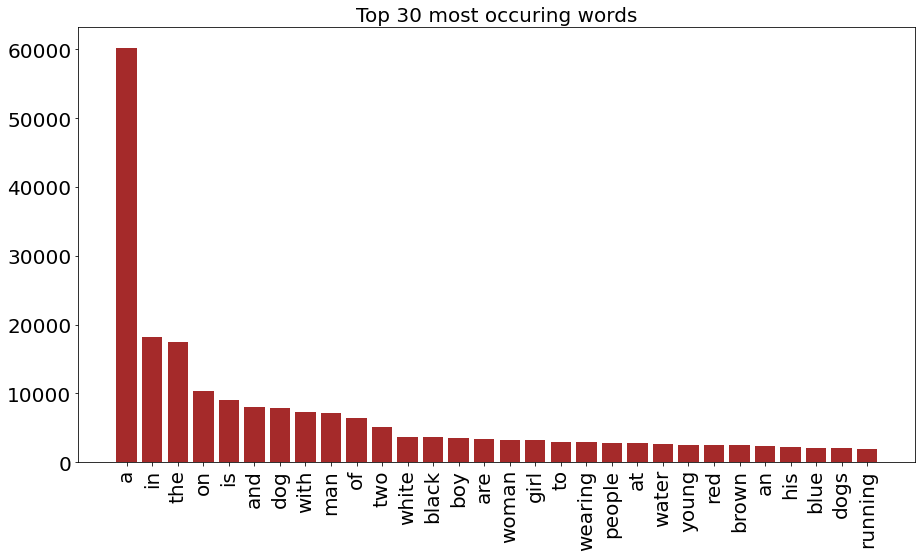

In [10]:
#Visualise the top 30 occuring words in the captions


#write your code here
sorted_tuples = sorted(vocabulary_count.items(), key=lambda item: item[1], reverse=True)
sorted_dict = {k: v for k, v in sorted_tuples}

vocabulary_count.most_common(30)

top_words = dict(vocabulary_count.most_common(30))

plt.figure(figsize=(15,8))

plt.bar(range(len(top_words)), list(top_words.values()), align='center', color='brown')
plt.xticks(range(len(top_words)), list(top_words.keys()),rotation=90, fontsize=20,color = 'black')
plt.yticks(fontsize=20,color ='black')
plt.title("Top 30 most occuring words",fontsize=20)

plt.show()

Insight

* As we can see in graph letter 'a' is having more count than other letter

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [11]:
# create the tokenizer

#your code here
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
                                                  )
tokenizer.fit_on_texts(annotations)

In [12]:
# Create word-to-index and index-to-word mappings.

#your code here
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

print('Word to Index:\n', word_index, '\n','='*100)
print('Index to Word:\n', index_word, '\n','='*100)

print('For Caption: \n', annotations[1], '\n','='*100)
print('The train sequence is: \n', train_sequences[1], '\n','='*100)

Word to Index:
 {'<unk>': 1, 'a': 2, '<start>': 3, '<end>': 4, 'in': 5, 'the': 6, 'on': 7, 'is': 8, 'and': 9, 'dog': 10, 'with': 11, 'man': 12, 'of': 13, 'two': 14, 'white': 15, 'black': 16, 'boy': 17, 'are': 18, 'woman': 19, 'girl': 20, 'to': 21, 'wearing': 22, 'people': 23, 'at': 24, 'water': 25, 'young': 26, 'red': 27, 'brown': 28, 'an': 29, 'his': 30, 'blue': 31, 'dogs': 32, 'running': 33, 'through': 34, 'playing': 35, 'shirt': 36, 'while': 37, 'down': 38, 'little': 39, 'standing': 40, 'ball': 41, 'grass': 42, 'person': 43, 'child': 44, 'snow': 45, 'jumping': 46, 'over': 47, 'three': 48, 'front': 49, 'sitting': 50, 'small': 51, 'up': 52, 'field': 53, 'holding': 54, 'large': 55, 'group': 56, 'by': 57, 'green': 58, 'yellow': 59, 'children': 60, 'walking': 61, 'men': 62, 'her': 63, 'into': 64, 'beach': 65, 'air': 66, 'near': 67, 'jumps': 68, 'mouth': 69, 'street': 70, 'runs': 71, 'for': 72, 'another': 73, 'riding': 74, 'from': 75, 'its': 76, 'as': 77, 'bike': 78, 'stands': 79, 'girls'

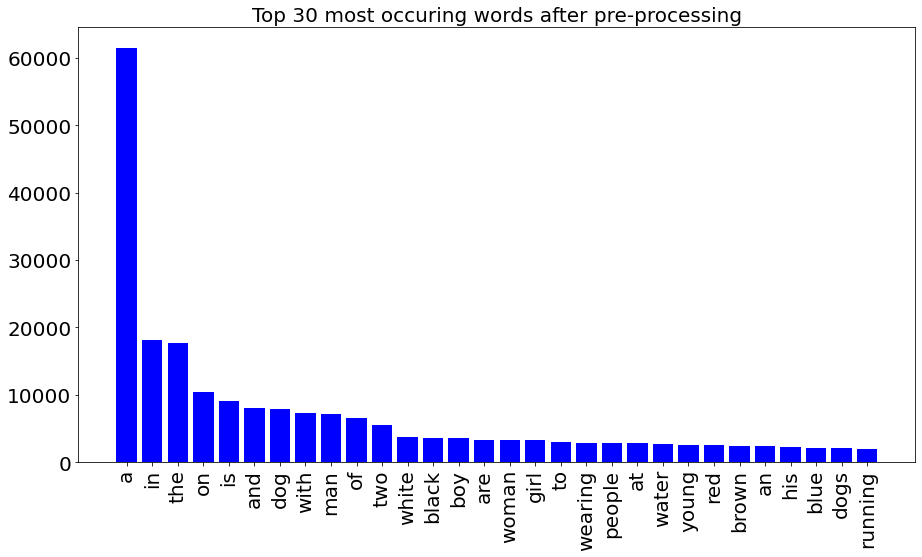

In [13]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
wordcount = tokenizer.word_counts

sorted_tuples = sorted(wordcount.items(), key=lambda item: item[1], reverse=True)

sorted_count = Counter({k: v for k, v in sorted_tuples if k != '<start>' and k !='<end>'})

top_words = dict(sorted_count.most_common(30))

plt.figure(figsize=(15,8))

plt.bar(range(len(top_words)), list(top_words.values()), align='center', color = 'blue')
plt.xticks(range(len(top_words)), list(top_words.keys()),rotation=90, fontsize=20,color = 'black')
plt.yticks(fontsize=20,color ='black')
plt.title("Top 30 most occuring words after pre-processing",fontsize=20)

plt.show()

In [14]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
maxlen = max([len(x) for x in train_sequences])

cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post',maxlen=maxlen,
                                                          dtype='int32', value=0)
 #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


In [15]:
print("\nPadded training sequences:\n", cap_vector,'\n','='*100)#displaying caption after padding


Padded training sequences:
 [[ 3  2 44 ...  0  0  0]
 [ 3  2 20 ...  0  0  0]
 [ 3  2 39 ...  0  0  0]
 ...
 [ 3  2 43 ...  0  0  0]
 [ 3  2 83 ...  0  0  0]
 [ 3  2 83 ...  0  0  0]] 


* We are padding zero at last using padding='post'. We know that start token acts as prompter and it expect some word after tat. Zero indicates no word and have no value at beginning.So,in order to not disturb the existing sequence structure we pad at end. This padding will cause problem while creating embedding vector.So we will be applying mask then.

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [16]:
#write your code here to create the dataset consisting of image paths
encode_train_set = sorted(set(all_img_vector))

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
print(encode_train_set)

['/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1000268201_693b08cb0e.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1001773457_577c3a7d70.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1002674143_1b742ab4b8.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1003163366_44323f5815.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1007129816_e794419615.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1007320043_627395c3d8.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1009434119_febe49276a.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1012212859_01547e3f17.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1015118661_980735411b.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1015584366_dfcec3c85a.jpg', '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/101654506_8eb26cfb60.jpg', '/content/

In [17]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
  #write your pre-processing steps here
    image  = tf.io.read_file(image_path)
    image  = tf.image.decode_jpeg(image, channels=3)
    image  = tf.image.resize(image, (299, 299))
    image  = tf.keras.applications.inception_v3.preprocess_input(image)
    return image , image_path

Shape after resize : (299, 299, 3)


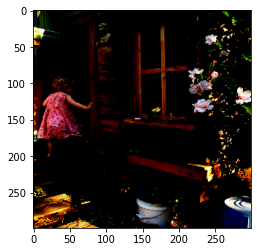

In [18]:
#sample image after the resize
img,img_path = load_image("/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/1000268201_693b08cb0e.jpg")
print("Shape after resize :", img.shape)
plt.imshow(img)

In [19]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
encode_train_set = sorted(set(all_img_vector))

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

image_data_set


<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input#write code here to get the input of the image_model
hidden_layer =image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model =tf.compat.v1.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

In [21]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)


# Get unique images
encode_train = sorted(set(all_img_path))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

#Images will be resized to (299,299,3) and will be normalized
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)

# print the resized image dataset
image_dataset



<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [22]:
#Save image features to .npy files
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")#This decoding is done because the values are not in ASCII
    np.save(path_of_feature, bf.numpy())#This will convert the tensor instance to numpy

100%|██████████| 127/127 [09:24<00:00,  4.44s/it]


In [23]:
batch_features#displaying batch features

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.00000000e+00, 7.73892775e-02, 0.00000000e+00, ...,
         2.32150659e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.07980251e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.94098771e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.85816810e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.65671742e+00, 0.00000000e+00],
        [0.00000000e+00, 4.02686775e-01, 0.00000000e+00, ...,
         0.00000000e+00, 3.17729205e-01, 0.00000000e+00],
        [0.00000000e+00, 2.53473401e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.25046718e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.86091834e-02, ...,
         1.20632231e+00, 0.

In [24]:
bf.shape#batch feature shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [25]:
#write your code here
# Shuffle captions and image_names together
all_img_path, cap_vector = shuffle(all_img_path,cap_vector,random_state=1)


path_train, path_test, cap_train, cap_test = train_test_split(all_img_path,cap_vector,test_size=0.2,random_state=42)

In [26]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [27]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
# Function to load image features

def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [28]:
# Set Batch and Buffer Size

BATCH_SIZE = 64
BUFFER_SIZE = 2000

In [29]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
def generate_dataset(img_data,cap_data):
  dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [30]:
train_dataset=generate_dataset(path_train,cap_train)
test_dataset=generate_dataset(path_test,cap_test)

In [31]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [32]:
embedding_dim = 256 
units = 512
vocab_size = top_k+1 #top 5,000 words +1
train_num_steps =len(path_train)// BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps =len(path_test)// BATCH_SIZE #len(total test images) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### Encoder

In [33]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense =tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features

In [34]:
encoder=Encoder(embedding_dim)

### Attention model

In [35]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =tf.expand_dims(hidden, 1)  # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

* The attention model does a linear transformation of the input.So we are applying tanh function on top of it.The features produced from dense layer(FC layer) of encoder and hidden state of decoder are passed to tanh function and attention score is calculated

* In other words, the tanh function is introduced to do non linear transformation and give smooth output .Since we need output in range (0,1), we apply softmax function on the obtained attention score which now gives the atttention weights.

* Finally we computed a weighted sum of the attention weights on the feature vector and thus, derived our context vector.

* This context vector produced are adaptive as they change for each and every time stamp.

### Decoder

In [36]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention =Attention_model(self.units) #iniitalise your Attention model with units
        self.embed =tf.keras.layers.Embedding(vocab_size, embedding_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 =tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights =self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =self.embed(x)  # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [37]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [38]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


* We know that the encoder output along with hidden state is passed to attention model.The attention model produces context vector.This context vector is concatenated with embedded vector formed from embedding layer and passed to GRU.
* After passing the GRU output to dense layers,finally we are trying to obtain output in shape of vocab_size as we need to assign probabilities for each and every word in vocabulary.

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [39]:
optimizer =tf.keras.optimizers.Adam(lr=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none') #define your loss object

In [40]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [41]:
checkpoint_path = "/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [43]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0])
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)

         # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for i in range(1, target.shape[1]):
          # passing encoder_output to the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)# to calculate gradients with respect to every trainable variable
    optimizer.apply_gradients(zip(gradients, trainable_variables))#compute gradients and apply it to the optimizer and backpropagate.

        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [44]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:#Record operations for automatic differentiation.
        features = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)# passing encoder_output to the decoder
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1) # using teacher forcing
          
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch


    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)# to calculate gradients with respect to every trainable variable
    optimizer.apply_gradients(zip(gradients, trainable_variables))#compute gradients and apply it to the optimizer and backpropagate.
  
            
    return loss, avg_loss

* We are using teacher forcing as training converges faster. Also, in the initial steps of training, the predictions of the model are very bad. 
* If we are not using it, the hidden states of the model might be updated with the sequence of wrong predictions because of the relational understanding present between words, and this mislead the model as errors will keep on adding, and the model will learn wrongly and perform badly at the end.So in order to train the model in right direction, we are doing this tweaking and forcing the model to predict correctly by passing the target word as the next input to the decoder

In [45]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
      batch_loss, t_loss = test_step(img_tensor, target)
      
      total_loss += t_loss
      avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [46]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.361, & test loss is 1.104
Time taken for 1 epoch 338.5223879814148 sec

Test loss has been reduced from 100.000 to 1.104


  7%|▋         | 1/15 [05:39<1:19:09, 339.25s/it]

For epoch: 2, the train loss is 1.026, & test loss is 0.969
Time taken for 1 epoch 246.62557721138 sec

Test loss has been reduced from 1.104 to 0.969


 13%|█▎        | 2/15 [09:46<1:01:47, 285.18s/it]

For epoch: 3, the train loss is 0.928, & test loss is 0.890
Time taken for 1 epoch 240.05708265304565 sec

Test loss has been reduced from 0.969 to 0.890


 20%|██        | 3/15 [13:47<52:59, 264.96s/it]  

For epoch: 4, the train loss is 0.860, & test loss is 0.831
Time taken for 1 epoch 232.06408143043518 sec

Test loss has been reduced from 0.890 to 0.831


 27%|██▋       | 4/15 [17:40<46:14, 252.24s/it]

For epoch: 5, the train loss is 0.803, & test loss is 0.778
Time taken for 1 epoch 235.48210835456848 sec

Test loss has been reduced from 0.831 to 0.778


 33%|███▎      | 5/15 [21:36<41:04, 246.50s/it]

For epoch: 6, the train loss is 0.754, & test loss is 0.733
Time taken for 1 epoch 232.27661061286926 sec

Test loss has been reduced from 0.778 to 0.733


 40%|████      | 6/15 [25:29<36:17, 241.98s/it]

For epoch: 7, the train loss is 0.711, & test loss is 0.691
Time taken for 1 epoch 305.80995893478394 sec

Test loss has been reduced from 0.733 to 0.691


 47%|████▋     | 7/15 [30:36<35:04, 263.10s/it]

For epoch: 8, the train loss is 0.670, & test loss is 0.652
Time taken for 1 epoch 367.0140724182129 sec

Test loss has been reduced from 0.691 to 0.652


 53%|█████▎    | 8/15 [36:44<34:35, 296.43s/it]

For epoch: 9, the train loss is 0.634, & test loss is 0.618
Time taken for 1 epoch 362.1641607284546 sec

Test loss has been reduced from 0.652 to 0.618


 60%|██████    | 9/15 [42:47<31:43, 317.27s/it]

For epoch: 10, the train loss is 0.600, & test loss is 0.584
Time taken for 1 epoch 366.7879865169525 sec

Test loss has been reduced from 0.618 to 0.584


 67%|██████▋   | 10/15 [48:54<27:43, 332.79s/it]

For epoch: 11, the train loss is 0.569, & test loss is 0.554
Time taken for 1 epoch 363.61154413223267 sec

Test loss has been reduced from 0.584 to 0.554


 73%|███████▎  | 11/15 [54:59<22:50, 342.56s/it]

For epoch: 12, the train loss is 0.539, & test loss is 0.526
Time taken for 1 epoch 367.81516218185425 sec

Test loss has been reduced from 0.554 to 0.526


 80%|████████  | 12/15 [1:01:08<17:31, 350.49s/it]

For epoch: 13, the train loss is 0.513, & test loss is 0.500
Time taken for 1 epoch 365.1913468837738 sec

Test loss has been reduced from 0.526 to 0.500


 87%|████████▋ | 13/15 [1:07:14<11:50, 355.23s/it]

For epoch: 14, the train loss is 0.489, & test loss is 0.476
Time taken for 1 epoch 368.85339617729187 sec

Test loss has been reduced from 0.500 to 0.476


 93%|█████████▎| 14/15 [1:13:24<05:59, 359.62s/it]

For epoch: 15, the train loss is 0.466, & test loss is 0.455
Time taken for 1 epoch 367.00858879089355 sec

Test loss has been reduced from 0.476 to 0.455


100%|██████████| 15/15 [1:19:32<00:00, 318.14s/it]


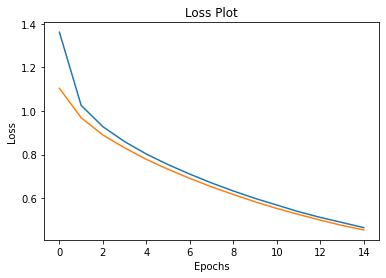

In [47]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [48]:
def evaluate(image):
    attention_plot = np.zeros((maxlen, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)


    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val =image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(maxlen):
        predictions, hidden, attention_weights =decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [49]:
# Define Evaluation function which uses Beam Search Algorithm

def beam_evaluate(image, beam_index=3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]
    
    attention_plot = np.zeros((maxlen, attention_features_shape))
    
    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    while len(result[0][0]) < maxlen:
        temp = []
        i = 0
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i = i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(predictions[0][w])
                temp.append([next_cap, prob])
                    
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
    
        predicted_id = result[-1]
        pred_list = predicted_id[0]
       
        prd_id = pred_list[-1] 
         
        if(prd_id!=4):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
        
    result = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    attention_plot = attention_plot[:len(final_caption), :]
    #final_caption = ' '.join(final_caption[1:])
    return final_caption

In [50]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
def filt_text(text):
    filt=['<start>','<unk>','<UNK>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BLEU score: 73.48499074383099
Real Caption: a woman plays a violin outdoors
Prediction Caption: a woman in a dress plays violin outdoors


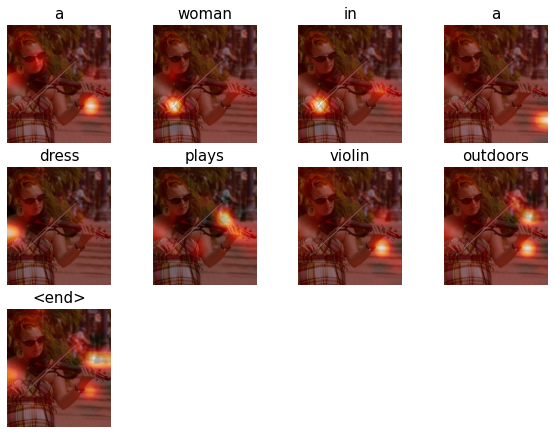

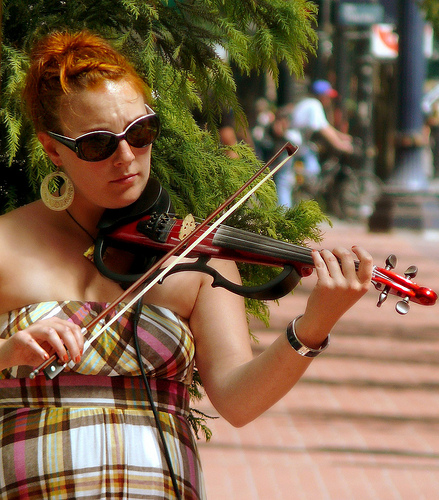

In [64]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = '/content/gdrive/MyDrive/Eye_for_blind-upgrad_capstone/Images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.2, 0.2, 0, 0))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

**Inferences observed:**

* The BLEU Score is almost 73 which is a really nice BLEU Score. This goes to say that the translation is near to perfect.
* The predicted caption is very much similar to the actual caption.

In [65]:
#this is optional beam Search
captions=beam_evaluate(test_image)
print(captions)

['<start>', 'a', 'little', 'wearing', 'a', 'dress']


# **Converting the caption to audio using Google Text-to-Speech(gTTS) API**

In [60]:
#!pip install gTTs


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
from gtts import gTTS
from IPython import display
from IPython.display import Audio 
#pred_caption='a child slides down a purple slide feet first'

tts = gTTS(pred_caption, slow = False)
tts.save('pred_caption.mp3')
sound_file = 'pred_caption.mp3'
Audio(sound_file, autoplay=True)

# **Summary:**

The Flickr8K dataset we have used for this capstone project is very small dataset, and training has been done on 80% of the dataset (i.e. approx 6500 images only).The project started with reading images and captions,displaying them.EDA is performed to understand about the given data set. Data cleaning is done which included cleaning caption file.

Data preprocessing is also performed which included :

* tokenizing the captions and forming an embeded vector, preprocessing images. Post that a data set is splitted into train and test dataset.

* InceptionV3 model is used.Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.

* Here in this project, we are not classifying the images. Rather,we only need to extract a feature vector for our images.Hence we are removing the softmax layer from the model. The shape of the output of this layer is 8x8x2048. Then we squeezed that to a shape of (64, 2048).

* This feature vector is given as input to CNN Encoder which had a single fully connected layer. To tell in abstract way,we can say that output from the encoder, hidden state(initialized to 0), and start token is passed as input to the decoder.

* The decoder (RNN -here GRU) attends over the image to predict the next word. We used the attention model to make our decoder focus on a particular part of the image at a time rather than focusing on the entire image. This also reduces noise and improves accuracy.The decoder returns the predicted caption and the decoder's hidden state as output. which is sent back to the model and the predictions are used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy".We also used teacher forcing to decide the next input to the decoder.

* The decoder stop predicting when the model predicts the end token.

* The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

* Finally, we are using the "BLEU score"(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption



# **NEXT STEPS:**


Also due to resource and time constraints, and keeping the scope of the capstone project in mind, the developed model could be improved further. However, it does a decent job with most of the test dataset pictures

Below are some of the known issues which can be improved in future -

* Some of the generated captions are not meaningful, sentences are not well formed. In some of the generated captions a word or a group of words are repeating multiple times (especially this can be observed in beam search results). Color could not be recognized properly in some images. Attention plot fails with error in some cases, where generated caption is only two words. Below steps can be taken in future (which is not in scope of this capstone project) to improve the accuracy of the model:

* Use bigger dataset for training. Bigger datasets like MS COCO, Stock3M etc. can be used to have more generalised model. Also bigger dataset will have more captions and vocabulary. Use more advanced Attention models such as: Multiheaded, Adaptive Attention with Visual Sentinel and, Semantic Attention. Implementing Transformer based models should give better results than GRU Try out models other than Inception V3, for image feature extractions More exhaustive hyper-parameter tuning could be performed.